# GLM Model : Pure Premium Model

#### Use StatsModel API : Poisson and Gamma Regression

Multi-variate Model 01 : Claim  Count - Claim Size Method

Model without Annual Milage as Predictor

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import statsmodels.api as sm

In [4]:
%matplotlib inline

## Part 1 : Training Data

### Read Data

In [5]:
data = pd.read_csv('data_purepremium_train.csv')

In [6]:
data.head(3)

,pol_id,ann_miles,rateclass,cgroup,tgroup,TotLoss,ClaimNum,EarnExpo
0,3222855,14831.0,1,A,5,0,0,1.000000
1,2650451,4789.0,1,A,4,0,0,0.666667
2,1400104,2994.0,1,A,4,0,0,1.000000


In [7]:
data.shape

(99947, 8)

###  Process Data

Filter Total Loss 

In [8]:
print( 'ClaimNumber before processing :', np.sum( data.ClaimNum>0) )
print(data.groupby(by=['ClaimNum']).size().values )

_TotLoss_ = data.apply( lambda x : 0.0 if x.TotLoss<50.0 else x.TotLoss, axis=1 )
data['TotLoss']  = _TotLoss_ 

_ClaimNum_ = data.apply( lambda x : 0.0 if x.TotLoss==0.0 else x.ClaimNum, axis=1 )
data['ClaimNum'] = _ClaimNum_

print( 'ClaimNumber after processing  :', np.sum( data.ClaimNum>0) )
print( data.groupby(by=['ClaimNum']).size().values )

ClaimNumber before processing : 4302
[95645  4117   178     7]
ClaimNumber after processing  : 4125
[95822  3942   176     7]


Check Agrregate Risks 

In [9]:
print( 'Claim Frequency :', round(data.ClaimNum.sum()/data.EarnExpo.sum(),4) ) 
print( 'Claim Severity  :', round(data.TotLoss.sum()/data.ClaimNum.sum(),2) ) 
print( 'Pure Premium    :', round( data.TotLoss.sum()/data.EarnExpo.sum(),2) ) 

Claim Frequency : 0.0496
Claim Severity  : 2954.24
Pure Premium    : 146.54


Select Columns

In [10]:
df = data[['cgroup','tgroup','rateclass','TotLoss','ClaimNum','EarnExpo']]

One-hot Encoding

In [11]:
def relevel(data, feature_name, base_level):
    
    if data[feature_name].dtype=='int':
        feature = data[feature_name].astype(str)
    else:
        feature = data[feature_name]
    
    categories = pd.CategoricalIndex(feature).categories
    categories = categories.to_numpy(dtype='str')
    
    base_level_index = np.where(categories==str(base_level))[0][0]
    
    _categories = np.delete( categories, base_level_index )
    categories = [str(base_level)] + list(_categories)

    releveled_feature = pd.CategoricalIndex(
        feature, 
        categories=categories,
        ordered=True)
    
    releveled_feature = releveled_feature.to_frame()
    
    return releveled_feature.reset_index(drop=True)

#### Categorical Data

In [12]:
_x1 = relevel(df, 'cgroup', 'A')
_x2 = relevel(df, 'tgroup', 6)
_x3 = relevel(df, 'rateclass', 1)

In [13]:
XC = pd.concat([_x1,_x2,_x3], axis=1)

### Model 1 : Claim Frequency

Get X,y

In [14]:
exog = pd.get_dummies( XC, drop_first=True )
exog = sm.add_constant(exog)

endog= df.ClaimNum.to_numpy()

In [15]:
offset   = np.log( df.EarnExpo.to_numpy() )
exposure = df.EarnExpo.to_numpy()

model_frequency = sm.GLM(
    endog, exog, 
    family=sm.families.Poisson(link=sm.families.links.log()), 
    offset=offset, 
    exposure=None, 
    freq_weights=None, 
    var_weights=None
)

results_frequency = model_frequency.fit()
print( results_frequency.summary() ) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                99947
Model:                            GLM   Df Residuals:                    99936
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17321.
Date:                Wed, 21 Dec 2022   Deviance:                       26277.
Time:                        21:39:30   Pearson chi2:                 9.99e+04
No. Iterations:                   100   Pseudo R-squ. (CS):           0.006007
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.6362      0.037    -70.884      

Claim Count Prediction

In [16]:
y_pred_f = model_frequency.predict(
    results_frequency.params, 
    exog=None, 
    exposure=None, 
    offset=None
)

[round(x,6) for x in y_pred_f[0:5]]

[0.054947, 0.03099, 0.046485, 0.039334, 0.046485]

In [17]:
np.quantile( y_pred_f, q=(0.0,0.25,0.50,0.75,1.0) )

array([0.00258738, 0.03327506, 0.03933422, 0.05372449, 0.40671167])

Total Claim Count : Actual vs Predicted

In [18]:
print( 'actual claim count    :', df.ClaimNum.sum() )
print( 'predicted claim count :', round(sum(y_pred_f),2) )

actual claim count    : 4315.0
predicted claim count : 4315.0


Eastimate Claim Count

In [19]:
_cols = list( results_frequency.params.index.values )
_beta = list( results_frequency.params.values )

In [20]:
key = np.array(
    ['intercept', 
     'cgroup_A','cgroup_B','cgroup_I','cgroup_M','cgroup_S',
     'tgroup_6','tgroup_1','tgroup_2','tgroup_3','tgroup_4','tgroup_5',
     'rateclass_1','rateclass_2','rateclass_3','rateclass_4'])

val = [_beta[0]] + [0.0] + _beta[1:5] 
val = val + [0.0] + _beta[5:10] + [0.0] + _beta[10:]

rel = np.array([ round(np.exp(x),4) for x in val]) 

In [21]:
_xc = pd.get_dummies( XC, drop_first=False )
_b = pd.DataFrame( np.column_stack((key,val,rel)), columns=['Feature','Estimate','Relativity'])

In [22]:
_b

,Feature,Estimate,Relativity
0,intercept,-2.6362042420874108,0.0716
1,cgroup_A,0.0,1.0
2,cgroup_B,0.08423971123297723,1.0879
3,cgroup_I,0.7842397150855659,2.1907
4,cgroup_M,-0.003244363903322667,0.9968
5,cgroup_S,-0.034627805735213325,0.966
6,tgroup_6,0.0,1.0
7,tgroup_1,-0.7667429938345469,0.4645
8,tgroup_2,-0.6402980271798726,0.5271
9,tgroup_3,-0.5994561908727508,0.5491


In [23]:
def calcFrequency(data, coef, exposure):
    
    D = data.values
    
    if coef['Estimate'].dtype=='object':
        b = coef['Estimate'].astype('float64').to_numpy()
    
    b0 = b[0]
    b1 = b[1:]
    
    f = []
    for i in range(D.shape[0]):
        
        m = 1
        for j in range(len(b1)): 
            m *= np.exp(D[i,j] * b1[j])
            
        f.append( m*np.exp(b0) )
        
    return np.array( exposure*f )

In [24]:
_e = np.exp( np.log(df.EarnExpo.values) )

calc_pred_f = calcFrequency(_xc,_b,_e)

q = np.quantile( calc_pred_f, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,6) for x in q]

[0.002587, 0.033275, 0.039334, 0.053724, 0.406712]

### Model 2 : Claim Severity

Get X,y 

In [25]:
df1 = df[ df.TotLoss > 0 ]

In [26]:
pos_loss_ind = df1.index.to_list()

In [27]:
_XC_ = XC.loc[pos_loss_ind, :]

In [28]:
exog = pd.get_dummies( _XC_, drop_first=True )
exog = sm.add_constant(exog)

endog= df1.TotLoss.to_numpy()

In [29]:
offset = np.log( df1.ClaimNum.to_numpy() )
exposure = df1.ClaimNum.to_numpy()

model_severity = sm.GLM(
    endog, exog, 
    family=sm.families.Gamma(link=sm.families.links.log()), 
    offset=offset, 
    exposure=None, 
    freq_weights=None, 
    var_weights=None
)

results_severity = model_severity.fit()
print( results_severity.summary() ) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4125
Model:                            GLM   Df Residuals:                     4114
Model Family:                   Gamma   Df Model:                           10
Link Function:                    log   Scale:                          2.3506
Method:                          IRLS   Log-Likelihood:                -37716.
Date:                Wed, 21 Dec 2022   Deviance:                       5651.4
Time:                        21:39:37   Pearson chi2:                 9.71e+03
No. Iterations:                   100   Pseudo R-squ. (CS):           0.003853
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.9820      0.058    136.707      

Claim Size Prediction

In [30]:
y_pred_s = model_severity.predict(results_severity.params, exog=None, exposure=None, offset=None)
[round(x,6) for x in y_pred_s[0:5]]

[2927.907319, 2755.660578, 2999.891163, 2538.420658, 2927.907319]

In [31]:
q = np.quantile( y_pred_s, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,6) for x in q]

[2331.75984, 2837.181446, 2938.197392, 2999.891163, 11538.751085]

Total Loss : Actual vs Predicted

In [32]:
print( 'actual claim amount    :', df.TotLoss.sum() )
print( 'predicted claim amount :', round(sum(y_pred_s),2) )

actual claim amount    : 12747526.0
predicted claim amount : 12730369.86


Eastimate Claim Size

In [33]:
_cols = list( results_severity.params.index.values )
_beta = list( results_severity.params.values )

In [34]:
key = np.array(
    ['intercept', 
     'cgroup_A','cgroup_B','cgroup_I','cgroup_M','cgroup_S',
     'tgroup_6','tgroup_1','tgroup_2','tgroup_3','tgroup_4','tgroup_5',
     'rateclass_1','rateclass_2','rateclass_3','rateclass_4'])

val = [_beta[0]] + [0.0] + _beta[1:5] 
val = val + [0.0] + _beta[5:10] + [0.0] + _beta[10:]

rel = np.array([ round(np.exp(x),4) for x in val]) 

In [35]:
_xc = pd.get_dummies( _XC_, drop_first=False )
_b = pd.DataFrame( np.column_stack((key,val,rel)), columns=['Feature','Estimate','Relativity'])

In [36]:
_b

,Feature,Estimate,Relativity
0,intercept,7.982043221303738,2927.9073
1,cgroup_A,0.0,1.0
2,cgroup_B,-0.15563643283969936,0.8559
3,cgroup_I,0.06660985200254727,1.0689
4,cgroup_M,0.10014734637500466,1.1053
5,cgroup_S,0.028566278431455667,1.029
6,tgroup_6,0.0,1.0
7,tgroup_1,0.02428806658479437,1.0246
8,tgroup_2,-0.14274584291465464,0.867
9,tgroup_3,0.010014014562935781,1.0101


In [37]:
def calcSeverity(data, coef, claimcount):
    
    D = data.values
    
    if coef['Estimate'].dtype=='object':
        b = coef['Estimate'].astype('float64').to_numpy()
    
    b0 = b[0]
    b1 = b[1:]
    
    s = []
    for i in range(D.shape[0]):
        
        m = 1
        for j in range(len(b1)): 
            m *= np.exp(D[i,j] * b1[j])
            
        s.append( m*np.exp(b0) )
        
    return np.array(claimcount * s)

In [38]:
_e = np.exp( np.log(df1.ClaimNum.values) )

calc_pred_s = calcSeverity(_xc,_b,_e)
print(round(calc_pred_s.sum(),4))

q = np.quantile( calc_pred_s, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,6) for x in q]

12730369.8569


[2331.75984, 2837.181446, 2938.197392, 2999.891163, 11538.751085]

-------------------------------------------------------------------------------------------------

#### Pure  Premium from Positive Loss Dataset

In [39]:
# Model Prediction  1
tot_loss_exp = y_pred_s
print('total loss expected  :', round(tot_loss_exp.sum(),4))

q = np.quantile( tot_loss_exp, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,4) for x in q]

total loss expected  : 12730369.8569


[2331.7598, 2837.1814, 2938.1974, 2999.8912, 11538.7511]

In [40]:
# Model Prediction 2
tot_loss_exp = calc_pred_s
print('total loss expected  :', round(tot_loss_exp.sum(),4))

q = np.quantile( tot_loss_exp, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,4) for x in q]

total loss expected  : 12730369.8569


[2331.7598, 2837.1814, 2938.1974, 2999.8912, 11538.7511]

In [41]:
pure_premium_exp = tot_loss_exp/df1.EarnExpo
print('pure premium expected:', round(sum(pure_premium_exp),1))

q = np.quantile( pure_premium_exp, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,4) for x in q]

pure premium expected: 14864598.8


[975.9691, 2837.1814, 2938.1974, 3176.2732, 45695.1142]

In [42]:
# Observed Data
tot_loss_act  = df1.TotLoss.sum()
print('total loss actual    :', round(tot_loss_act,1))

pure_premium_act = df1.TotLoss/df1.EarnExpo
print('pure premium actual  :', round(sum(pure_premium_act),1))

q = np.quantile( pure_premium_act, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,4) for x in q]

total loss actual    : 12747526.0
pure premium actual  : 15220807.3


[50.0, 708.0, 1514.0, 3475.0, 153792.0006]

#### Pure Premium for the Entire Dataset

Actual Loss

In [43]:
loss_actual = df.TotLoss.sum()
print('Actual Loss :', round(loss_actual,4) )

Actual Loss : 12747526.0


Expected Loss = Loss Cost = Pure Premium

In [44]:
exog = pd.get_dummies( XC, drop_first=True )
exog = sm.add_constant(exog)

# frequency 
y_pred_f = model_frequency.predict(
    results_frequency.params, 
    exog=exog, 
    exposure=None, 
    offset=None
)

# severity 
y_pred_s = model_severity.predict(
    results_severity.params, 
    exog=exog, 
    exposure=None, 
    offset=None
)

In [45]:
"""Expected Total Claim Count from Claim Frequency"""
count_expected =  y_pred_f * df.EarnExpo
print('Expected Claim Count :', round(count_expected.sum(),2))

Expected Claim Count : 4315.0


In [46]:
"""Expected Total Loss from Claim Severity"""
loss_expected =  y_pred_s * df.ClaimNum
print('Expected Total Loss :', round(loss_expected.sum(),2))

Expected Total Loss : 12730369.86


In [47]:
pure_premium = y_pred_f * y_pred_s
print('Total Pure Premium :',  round(pure_premium.sum(),2))

q = np.quantile( pure_premium, q=(0.0,0.25,0.50,0.75,1.0) )
print('Pure Premium Quartile :', [round(x,4) for x in q] )

Total Pure Premium : 14865307.94
Pure Premium Quartile : [94.696, 99.8215, 131.8876, 161.4444, 774.364]


In [48]:
y_pred_l = pure_premium * df.EarnExpo.values
loss_expected = np.sum( y_pred_l )
print('Expected Total Loss :', round(loss_expected,2) )

Expected Total Loss : 12730342.4


#### Model Performance on  Training Data

Example : A/E for Entire Dataset  

In [49]:
A_by_E = loss_actual/loss_expected
A_by_E

1.0013498143520707

Example : loss A/E (Data is Grouped by Variables)

In [50]:
tmp = df.copy()
tmp['PredFrequency'] = y_pred_f
tmp['PredSeverity']  = y_pred_s
tmp['ExpectedLoss']  = y_pred_l

In [51]:
grp1 = tmp.groupby(by=['cgroup'], as_index=True)
res1 = grp1.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })

grp2 = tmp.groupby(by=['tgroup'], as_index=True)
res2 = grp2.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })

grp3 = tmp.groupby(by=['rateclass'], as_index=True)
res3 = grp3.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })


y_driver_age =[res1.values[x]['AE'] for x in range(res1.shape[0])]
x_driver_age =list(res1.index)

y_vehicle_age =[res2.values[x]['AE'] for x in range(res2.shape[0])]
x_vehicle_age =list(res2.index)

y_license_year =[res3.values[x]['AE'] for x in range(res3.shape[0])]
x_license_year =list(res3.index)

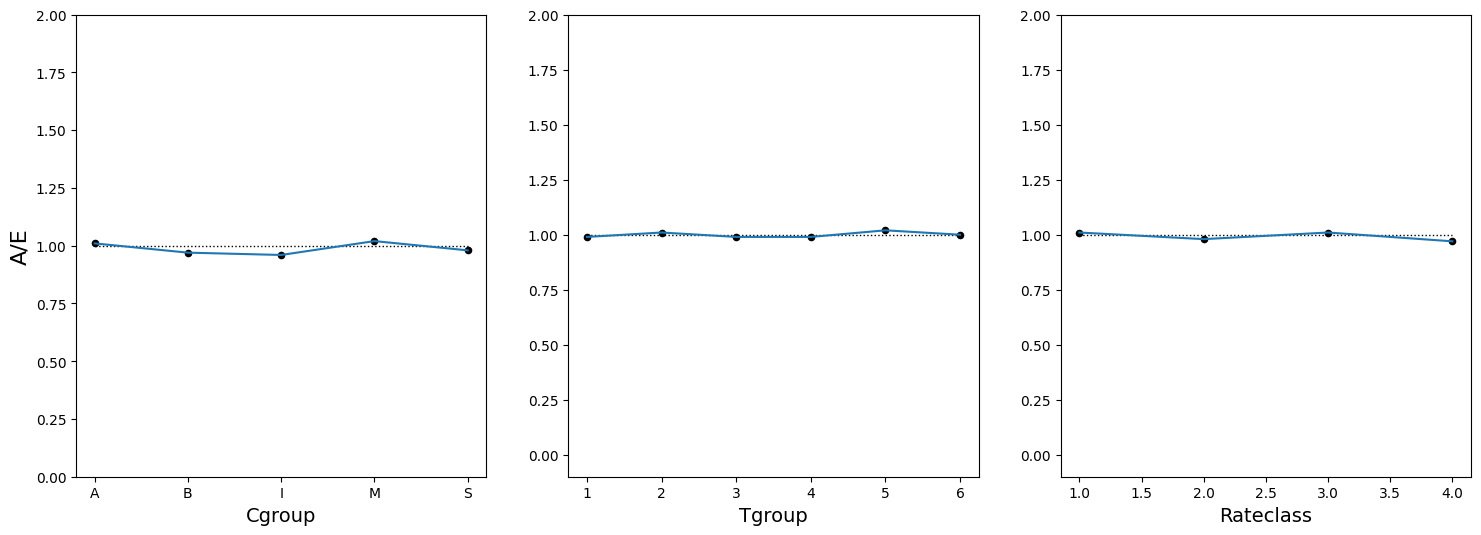

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

x = x_driver_age
y = np.ones( len(x) )
ax[0].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[0].scatter(x_driver_age, y_driver_age, s=20, color='black')
ax[0].plot(x_driver_age, y_driver_age, linestyle='solid')
ax[0].set_ylim(-0.,2)
ax[0].set_ylabel('A/E', fontdict={'size':16})
ax[0].set_xlabel('Cgroup', fontdict={'size':14})

x = x_vehicle_age
y = np.ones( len(x) )
ax[1].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[1].scatter(x_vehicle_age, y_vehicle_age, s=20, color='black')
ax[1].plot(x_vehicle_age, y_vehicle_age, linestyle='solid')
ax[1].set_ylim(-0.1,2)
ax[1].set_xlabel('Tgroup', fontdict={'size':14})

x = x_license_year
y = np.ones( len(x) )
ax[2].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[2].scatter(x_license_year, y_license_year, s=20, color='black')
ax[2].plot(x_license_year, y_license_year, linestyle='solid')
ax[2].set_ylim(-0.1,2)
ax[2].set_xlabel('Rateclass', fontdict={'size':14})

plt.show()

Example : Frequency A/E (Data is Grouped by Variables)

In [53]:
def frequency_A_by_E(data, feature):
    
    grp = data.groupby(by=[feature], as_index=True)
    
    res = grp.apply(lambda x : 
                {'A': x.ClaimNum.sum()/x.EarnExpo.sum(),         
                 'E': (x.PredFrequency*x.EarnExpo).sum()/x.EarnExpo.sum(),   
                 'AE':round(x.ClaimNum.sum()/(x.PredFrequency*x.EarnExpo).sum(),2)
                })
    return res


res1 = frequency_A_by_E(tmp, 'cgroup')
res2 = frequency_A_by_E(tmp, 'tgroup')
res3 = frequency_A_by_E(tmp, 'rateclass')
    
y_cgroup =[res1.values[x]['AE'] for x in range(res1.shape[0])]
x_cgroup =list(res1.index)

y_tgroup =[res2.values[x]['AE'] for x in range(res2.shape[0])]
x_tgroup =list(res2.index)

y_rateclass =[res3.values[x]['AE'] for x in range(res3.shape[0])]
x_rateclass =list(res3.index)

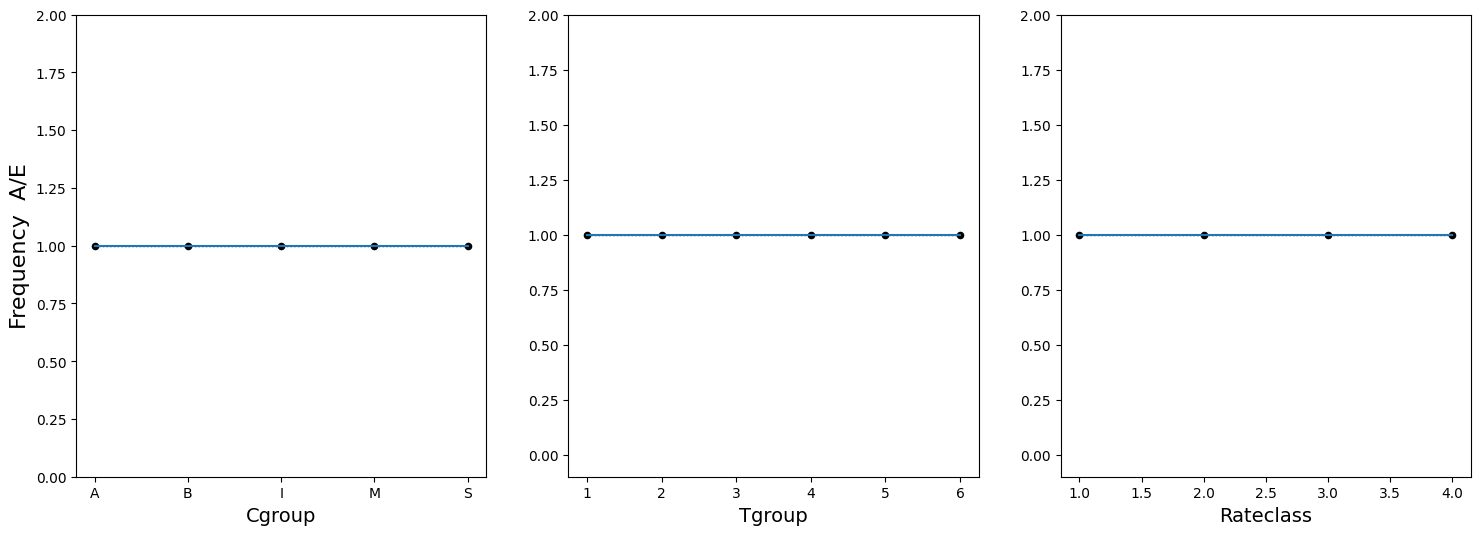

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

x = x_cgroup
y = np.ones( len(x) )
ax[0].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[0].scatter(x_cgroup, y_cgroup, s=20, color='black')
ax[0].plot(x_cgroup, y_cgroup, linestyle='solid')
ax[0].set_ylim(-0.,2)
ax[0].set_ylabel('Frequency  A/E', fontdict={'size':16})
ax[0].set_xlabel('Cgroup', fontdict={'size':14})

x = x_tgroup
y = np.ones( len(x) )
ax[1].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[1].scatter(x_tgroup, y_tgroup, s=20, color='black')
ax[1].plot(x_tgroup, y_tgroup, linestyle='solid')
ax[1].set_ylim(-0.1,2)
ax[1].set_xlabel('Tgroup', fontdict={'size':14})

x = x_rateclass
y = np.ones( len(x) )
ax[2].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[2].scatter(x_rateclass, y_rateclass, s=20, color='black')
ax[2].plot(x_rateclass, y_rateclass, linestyle='solid')
ax[2].set_ylim(-0.1,2)
ax[2].set_xlabel('Rateclass', fontdict={'size':14})

plt.show()

Example : Pure Premium vs Average Claim Amount

In [55]:
obs_loss = df['TotLoss'].values
exposure = df['EarnExpo'].values
pure_prm = y_pred_f * y_pred_s
exp_loss = y_pred_l

tmp =  pd.DataFrame( 
    np.column_stack((obs_loss, exposure, pure_prm, exp_loss)), 
    columns=['Actual','Exposure','PurePremium','Expected'])

In [56]:
## General Equal-Width Bins
tmp1 = tmp.sort_values(by=['PurePremium'], inplace=False).reset_index(drop=True)

nbins = 10
ppBins = pd.cut( 
    tmp1.PurePremium.to_numpy(), 
    nbins,
    right=True, include_lowest=True, 
    ordered=True)

tmp1['ppGroups'] = ppBins

grp1 = tmp1.groupby(by=['ppGroups'], as_index=False).agg(
    {'Actual':'mean', 
     'Exposure':'sum', 
     'PurePremium':'mean', 
     'Expected': 'mean', 
     'ppGroups': 'count'
    })



## Quantile Equal-Frequency  Bins
tmp2 = tmp.sort_values(by=['PurePremium'], inplace=False).reset_index(drop=True)

nbins = 10
ppBins = pd.qcut( 
    tmp2.PurePremium.to_numpy(), 
    nbins,
    duplicates = 'drop')

tmp2['ppGroups'] = ppBins

grp2 = tmp2.groupby(by=['ppGroups'], as_index=False).agg(
    {'Actual':'mean', 
     'Exposure':'sum', 
     'PurePremium':'mean', 
     'Expected': 'mean',
     'ppGroups': 'count'
    })

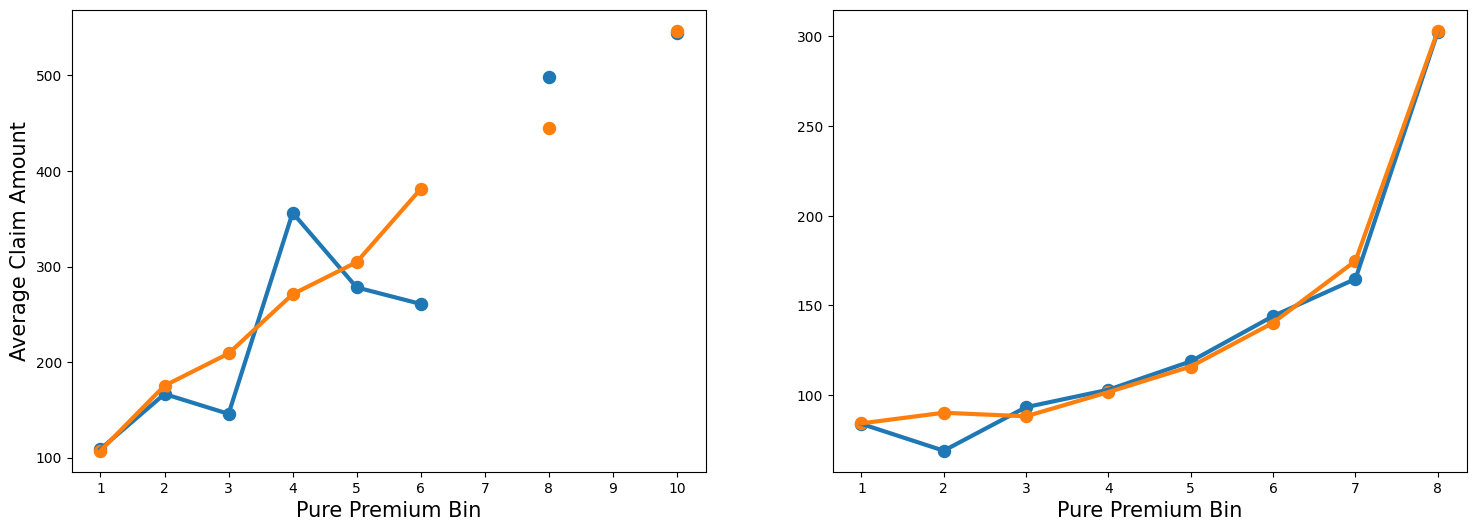

In [57]:
fig, ax = plt.subplots(1,2, figsize=(18,6))

x1 = 1
x2 = grp1.shape[0]+1
ax[0].scatter( np.arange(x1,x2), grp1.Actual.to_list(), color='tab:blue', s=75)
ax[0].plot( np.arange(x1,x2), grp1.Actual.to_numpy(), color='tab:blue', linewidth=3)
ax[0].scatter( np.arange(x1,x2),  grp1.Expected.to_numpy(), color='tab:orange', s=75)
ax[0].plot( np.arange(x1,x2), grp1.Expected.to_numpy(), color='tab:orange', linewidth=3)
ax[0].set_xticks(np.arange(x1,x2))
ax[0].set_xlabel('Pure Premium Bin', fontdict={'size':15})
ax[0].set_ylabel('Average Claim Amount', fontdict={'size':15})
#ax[0].text(1, 315, 'Equal-Width Bins', fontdict={'size':12})


x1 = 1
x2 = grp2.shape[0]+1
ax[1].scatter( np.arange(x1,x2), grp2.Actual.to_list(), color='tab:blue', s=75)
ax[1].plot( np.arange(x1,x2), grp2.Actual.to_numpy(), color='tab:blue', linewidth=3)

ax[1].scatter( np.arange(x1,x2),  grp2.Expected.to_numpy(), color='tab:orange', s=75)
ax[1].plot( np.arange(x1,x2), grp2.Expected.to_numpy(), color='tab:orange', linewidth=3)

ax[1].set_xticks(np.arange(x1,x2))
ax[1].set_xlabel('Pure Premium Bin', fontdict={'size':15})
#ax[1].text(1, 120, 'Equal-Frequency Bins', fontdict={'size':12})

plt.show()

Example : Gini Index

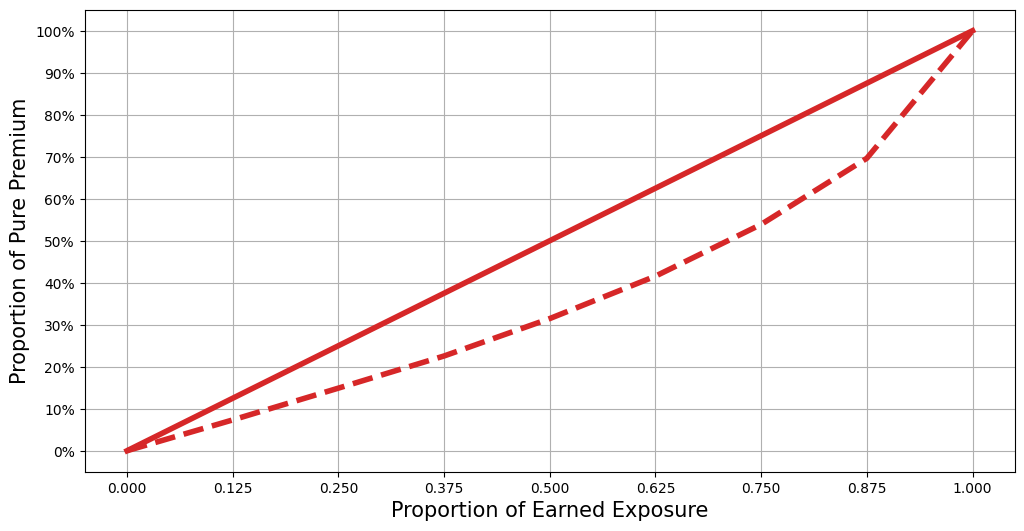

In [58]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

pp_frac = np.cumsum( grp2.PurePremium.to_numpy() )
pp_frac = pp_frac/pp_frac.max()
pp_frac = 100 * np.array( [0] + list(pp_frac) )


x1 = 0
x2 = grp2.shape[0]+1
x = np.arange(x1,x2)
x = x/x.max()
y = 100*x
ax.plot( x, y, color='tab:red', linewidth=4)


ax.plot( x, pp_frac, color='tab:red', linewidth=4, linestyle='dashed')
ax.set_xticks( x )

ax.set_xlabel('Proportion of Earned Exposure', fontdict={'size':15})
ax.set_ylabel('Proportion of Pure Premium', fontdict={'size':15})
ax.set_yticks( np.arange(0,101,10) )
ax.set_yticklabels( [str(x)+'%' for x in np.arange(0,101,10)] )
ax.grid(True)


plt.show()

Calculate Gini Index

In [59]:
def gini_index(xp,yp,delta):
    
    dln = len(xp)
    
    if any(yp > 1.0):
        yp = yp/100.
    else:
        yp = yp

    x  = np.arange(0,1,delta)
    y  = np.interp(x, xp, yp)

    area_b = np.trapz(y, x)
    area_a = 0.5-area_b
    
    gini_index = area_a/(area_a+area_b)
    
    return  gini_index

In [60]:
xp = x
yp = pp_frac
delta = 0.01
gini_index(xp,yp,delta)

0.29135706010911855

-------------------------------------------------------------------------------------------------

## Part 2 : Validation Data

In [61]:
data = pd.read_csv('data_purepremium_valid.csv')
df = data[['ann_miles','cgroup','tgroup','rateclass','TotLoss','ClaimNum','EarnExpo']]

Check Agrregate Risks 

In [62]:
print( 'Claim Frequency :', round(data.ClaimNum.sum()/data.EarnExpo.sum(),4) ) 
print( 'Claim Severity  :', round(data.TotLoss.sum()/data.ClaimNum.sum(),2) ) 
print( 'Pure Premium    :', round( data.TotLoss.sum()/data.EarnExpo.sum(),2) ) 

Claim Frequency : 0.0496
Claim Severity  : 2815.89
Pure Premium    : 139.56


Categorical Data

In [63]:
_x1 = relevel(df, 'cgroup', 'A')
_x2 = relevel(df, 'tgroup', 6)
_x3 = relevel(df, 'rateclass', 1)

In [64]:
XC = pd.concat([_x1,_x2,_x3], axis=1)

Get X

In [65]:
exog = pd.get_dummies( XC, drop_first=True )
exog = sm.add_constant(exog)

Claim Frequency Prediction

In [66]:
y_pred_f = model_frequency.predict(
    results_frequency.params, 
    exog=exog, 
    exposure=None, 
    offset=None)

y_pred_f[0:5]

array([0.03327506, 0.0377601 , 0.03670229, 0.0377601 , 0.0352335 ])

Summary Statistics of Claim Frequency Prediction

In [67]:
np.quantile( y_pred_f, q=(0.0,0.25,0.50,0.75,1.0) )

array([0.03104856, 0.0377601 , 0.04648542, 0.05494675, 0.20335583])

Claim Severity Prediction

In [68]:
y_pred_s = model_severity.predict(
    results_severity.params, 
    exog=exog, 
    exposure=None, 
    offset=None)

y_pred_s[0:5]

array([2999.89116269, 2538.42065789, 3131.25697611, 2538.42065789,
       2687.6700242 ])

Summary Statistics of Claim Severity Prediction

In [69]:
np.quantile( y_pred_s, q=(0.0,0.25,0.50,0.75,1.0) )

array([2331.75983978, 2837.18144612, 2938.19739246, 2999.89116269,
       4034.61260353])

Actual Loss

In [70]:
loss_actual = df.TotLoss.sum()
print('Actual Loss :', round(loss_actual,4) )

Actual Loss : 6059796


Expected Loss

In [71]:
"""Expected Total Loss from Claim Severity"""
loss_expected_s =  y_pred_s * df.ClaimNum

print('Expected Total Loss :', round(loss_expected_s.sum(),2) )

Expected Total Loss : 6344262.76


In [72]:
pure_premium = y_pred_f * y_pred_s

print('Pure Premium Values   :', [round(x,4) for x in pure_premium[0:5]], '\n')

q = np.quantile( pure_premium, q=(0.0,0.25,0.50,0.75,1.0) )
print('Pure Premium Quartile :', [round(x,4) for x in q] )

Pure Premium Values   : [99.8215, 95.851, 114.9243, 95.851, 94.696] 

Pure Premium Quartile : [94.696, 99.8215, 131.8876, 161.4444, 774.364]


In [73]:
y_pred_l = pure_premium * df.EarnExpo.values
loss_expected = np.sum( y_pred_l )
print('Expected Total Loss :', round(loss_expected,2) )

Expected Total Loss : 6376159.42


#### Model Performance on Validation data

Example : Frequency A/E (Entire Dataset)

In [74]:
A_by_E = df.ClaimNum.sum()/np.sum(y_pred_f*df.EarnExpo)
A_by_E

0.9961225007123413

Example : Loss A/E (Entire Dataset)

In [75]:
A_by_E = loss_actual/loss_expected
A_by_E

0.9503833888203164

Example : Loss A/E (Data is Grouped by Variables)

In [76]:
tmp = df.copy()
tmp['PredFrequency'] = y_pred_f
tmp['PredSeverity']  = y_pred_s
tmp['ExpectedLoss']  = y_pred_l

In [77]:
def severity_A_by_E(data, feature):
    
    grp = data.groupby(by=[feature], as_index=True)
    res = grp.apply(lambda x : 
                     {'A': sum(x.TotLoss*x.EarnExpo),        # weighted by exposure 
                      'E': sum(x.ExpectedLoss*x.EarnExpo),   # weighted by exposure
                      'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                     })    
    return res


res1 = severity_A_by_E(tmp, 'cgroup')
res2 = severity_A_by_E(tmp, 'tgroup')
res3 = severity_A_by_E(tmp, 'rateclass')


y_cgroup =[res1.values[x]['AE'] for x in range(res1.shape[0])]
x_cgroup =list(res1.index)

y_tgroup =[res2.values[x]['AE'] for x in range(res2.shape[0])]
x_tgroup =list(res2.index)

y_rateclass =[res3.values[x]['AE'] for x in range(res3.shape[0])]
x_rateclass =list(res3.index)

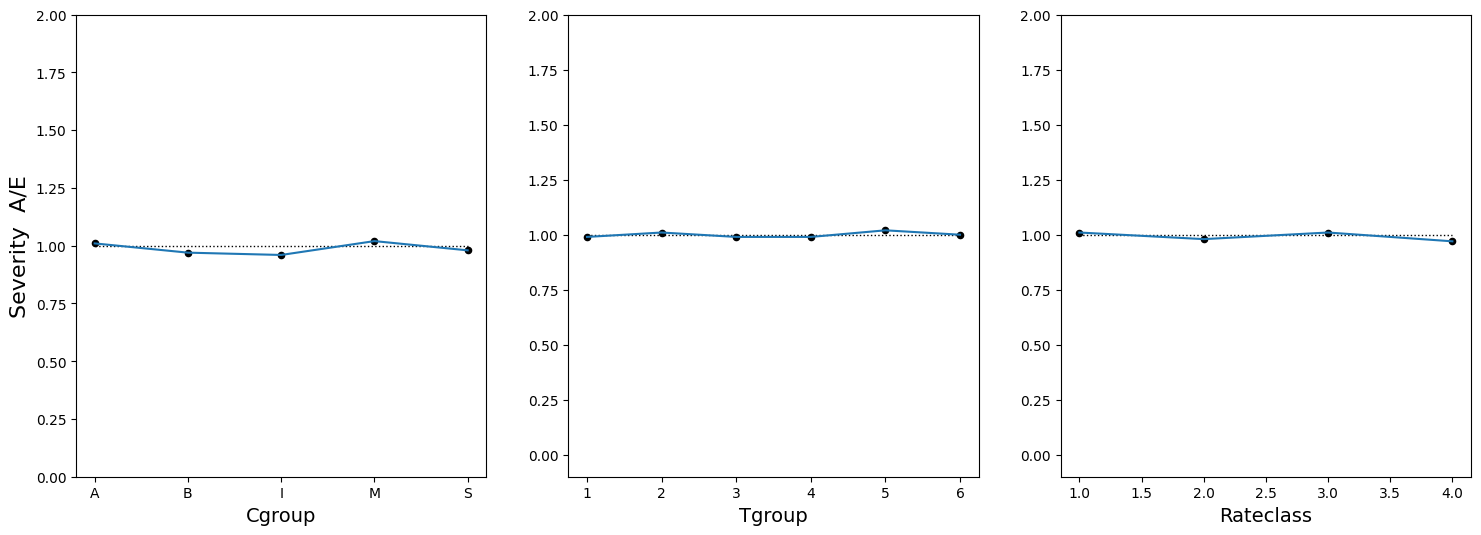

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

x = x_driver_age
y = np.ones( len(x) )
ax[0].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[0].scatter(x_driver_age, y_driver_age, s=20, color='black')
ax[0].plot(x_driver_age, y_driver_age, linestyle='solid')
ax[0].set_ylim(-0.,2)
ax[0].set_ylabel('Severity  A/E', fontdict={'size':16})
ax[0].set_xlabel('Cgroup', fontdict={'size':14})

x = x_vehicle_age
y = np.ones( len(x) )
ax[1].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[1].scatter(x_vehicle_age, y_vehicle_age, s=20, color='black')
ax[1].plot(x_vehicle_age, y_vehicle_age, linestyle='solid')
ax[1].set_ylim(-0.1,2)
ax[1].set_xlabel('Tgroup', fontdict={'size':14})

x = x_license_year
y = np.ones( len(x) )
ax[2].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[2].scatter(x_license_year, y_license_year, s=20, color='black')
ax[2].plot(x_license_year, y_license_year, linestyle='solid')
ax[2].set_ylim(-0.1,2)
ax[2].set_xlabel('Rateclass', fontdict={'size':14})

plt.show()

Example : Frequency A/E (Data is Grouped by Variables)

In [79]:
def frequency_A_by_E(data, feature):
    
    grp = data.groupby(by=[feature], as_index=True)
    
    res = grp.apply(lambda x : 
                {'A': x.ClaimNum.sum()/x.EarnExpo.sum(),         
                 'E': (x.PredFrequency*x.EarnExpo).sum()/x.EarnExpo.sum(),   
                 'AE':round(x.ClaimNum.sum()/(x.PredFrequency*x.EarnExpo).sum(),2)
                })
    return res


res1 = frequency_A_by_E(tmp, 'cgroup')
res2 = frequency_A_by_E(tmp, 'tgroup')
res3 = frequency_A_by_E(tmp, 'rateclass')
    
y_cgroup =[res1.values[x]['AE'] for x in range(res1.shape[0])]
x_cgroup =list(res1.index)

y_tgroup =[res2.values[x]['AE'] for x in range(res2.shape[0])]
x_tgroup =list(res2.index)

y_rateclass =[res3.values[x]['AE'] for x in range(res3.shape[0])]
x_rateclass =list(res3.index)

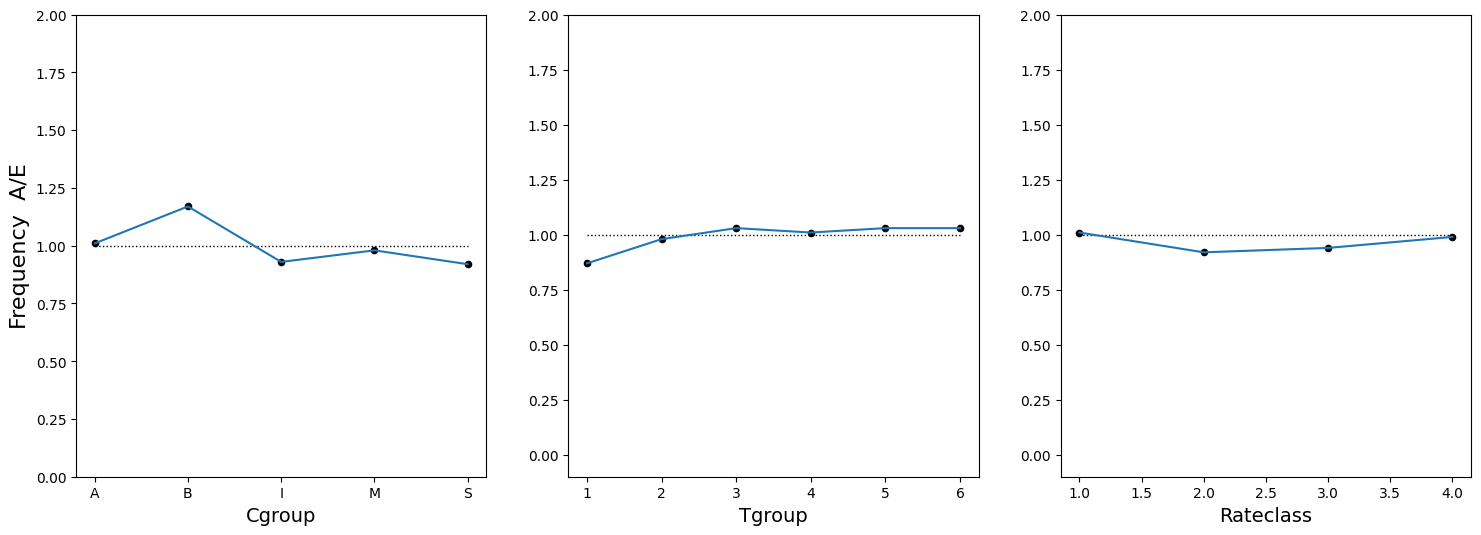

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

x = x_cgroup
y = np.ones( len(x) )
ax[0].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[0].scatter(x_cgroup, y_cgroup, s=20, color='black')
ax[0].plot(x_cgroup, y_cgroup, linestyle='solid')
ax[0].set_ylim(-0.,2)
ax[0].set_ylabel('Frequency  A/E', fontdict={'size':16})
ax[0].set_xlabel('Cgroup', fontdict={'size':14})

x = x_tgroup
y = np.ones( len(x) )
ax[1].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[1].scatter(x_tgroup, y_tgroup, s=20, color='black')
ax[1].plot(x_tgroup, y_tgroup, linestyle='solid')
ax[1].set_ylim(-0.1,2)
ax[1].set_xlabel('Tgroup', fontdict={'size':14})

x = x_rateclass
y = np.ones( len(x) )
ax[2].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[2].scatter(x_rateclass, y_rateclass, s=20, color='black')
ax[2].plot(x_rateclass, y_rateclass, linestyle='solid')
ax[2].set_ylim(-0.1,2)
ax[2].set_xlabel('Rateclass', fontdict={'size':14})

plt.show()

Example : Pure Premium vs Average Claim Amount

In [81]:
obs_loss = df['TotLoss'].values
exposure = df['EarnExpo'].values
pure_prm = y_pred_f * y_pred_s
exp_loss = y_pred_l

tmp =  pd.DataFrame( 
    np.column_stack((obs_loss, exposure, pure_prm, exp_loss)), 
    columns=['Actual','Exposure','PurePremium','Expected'])

In [82]:
## General Equal-Width Bins
tmp1 = tmp.sort_values(by=['PurePremium'], inplace=False).reset_index(drop=True)

nbins = 10
ppBins = pd.cut( 
    tmp1.PurePremium.to_numpy(), 
    nbins,
    right=True, include_lowest=True, 
    ordered=True)

tmp1['ppGroups'] = ppBins

grp1 = tmp1.groupby(by=['ppGroups'], as_index=False).agg(
    {'Actual':'mean', 
     'Exposure':'sum', 
     'PurePremium':'mean', 
     'Expected': 'mean', 
     'ppGroups': 'count'
    })



## Quantile Equal-Frequency  Bins
tmp2 = tmp.sort_values(by=['PurePremium'], inplace=False).reset_index(drop=True)

nbins = 10
ppBins = pd.qcut( 
    tmp2.PurePremium.to_numpy(), 
    nbins,
    duplicates = 'drop')

tmp2['ppGroups'] = ppBins

grp2 = tmp2.groupby(by=['ppGroups'], as_index=False).agg(
    {'Actual':'mean', 
     'Exposure':'sum', 
     'PurePremium':'mean', 
     'Expected': 'mean',
     'ppGroups': 'count'
    })

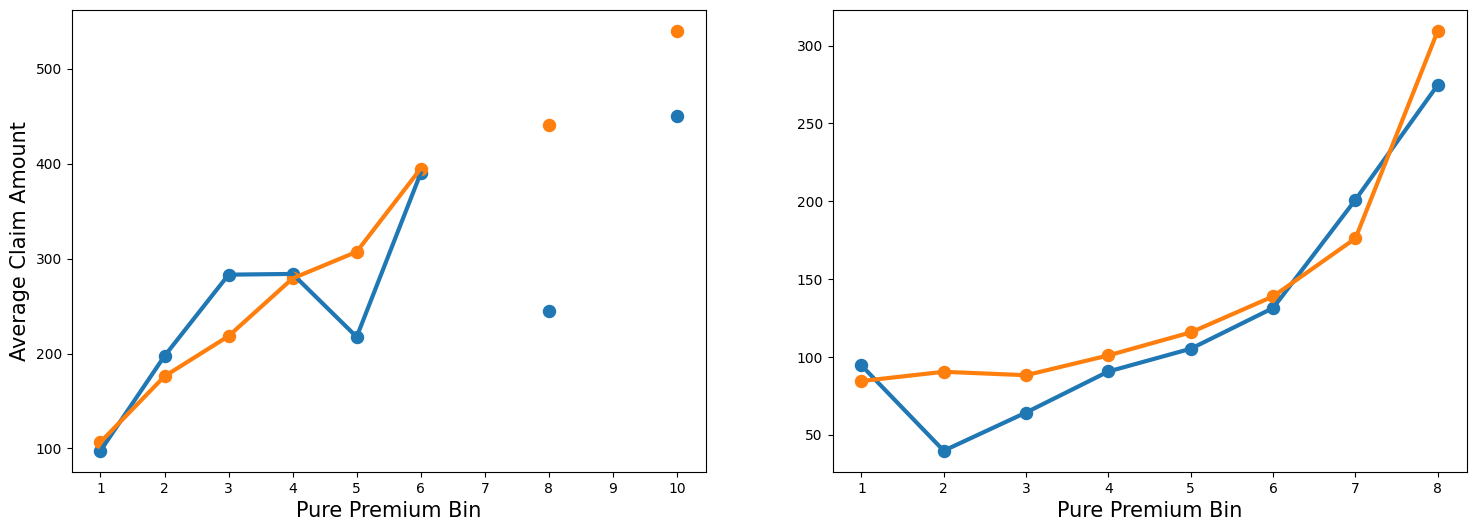

In [83]:
fig, ax = plt.subplots(1,2, figsize=(18,6))

x1 = 1
x2 = grp1.shape[0]+1
ax[0].scatter( np.arange(x1,x2), grp1.Actual.to_list(), color='tab:blue', s=75)
ax[0].plot( np.arange(x1,x2), grp1.Actual.to_numpy(), color='tab:blue', linewidth=3)
ax[0].scatter( np.arange(x1,x2),  grp1.Expected.to_numpy(), color='tab:orange', s=75)
ax[0].plot( np.arange(x1,x2), grp1.Expected.to_numpy(), color='tab:orange', linewidth=3)
ax[0].set_xticks(np.arange(x1,x2))
ax[0].set_xlabel('Pure Premium Bin', fontdict={'size':15})
ax[0].set_ylabel('Average Claim Amount', fontdict={'size':15})
#ax[0].text(1, 315, 'Equal-Width Bins', fontdict={'size':12})


x1 = 1
x2 = grp2.shape[0]+1
ax[1].scatter( np.arange(x1,x2), grp2.Actual.to_list(), color='tab:blue', s=75)
ax[1].plot( np.arange(x1,x2), grp2.Actual.to_numpy(), color='tab:blue', linewidth=3)

ax[1].scatter( np.arange(x1,x2),  grp2.Expected.to_numpy(), color='tab:orange', s=75)
ax[1].plot( np.arange(x1,x2), grp2.Expected.to_numpy(), color='tab:orange', linewidth=3)

ax[1].set_xticks(np.arange(x1,x2))
ax[1].set_xlabel('Pure Premium Bin', fontdict={'size':15})
#ax[1].text(1, 120, 'Equal-Frequency Bins', fontdict={'size':12})

plt.show()

Example : Gini Index

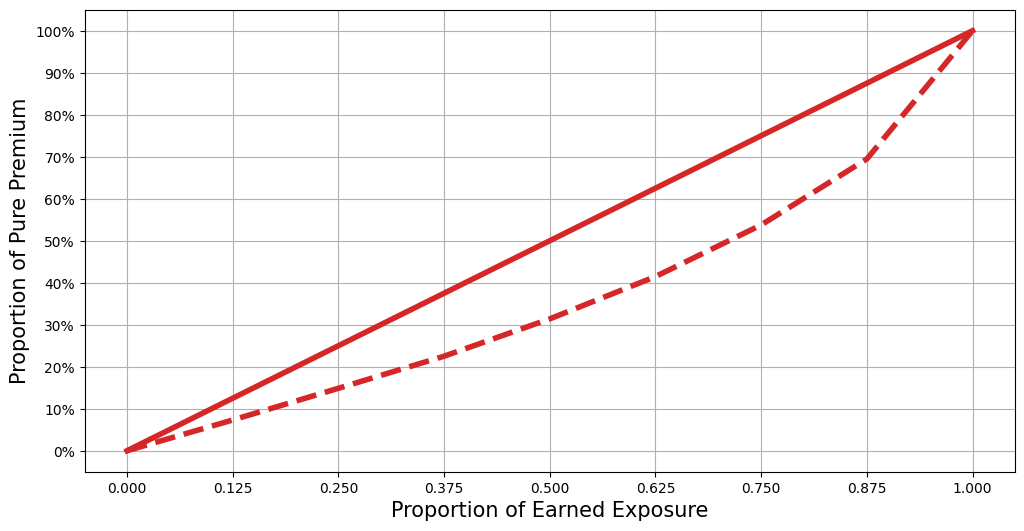

In [84]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

pp_frac = np.cumsum( grp2.PurePremium.to_numpy() )
pp_frac = pp_frac/pp_frac.max()
pp_frac = 100 * np.array( [0] + list(pp_frac) )


x1 = 0
x2 = grp2.shape[0]+1
x = np.arange(x1,x2)
x = x/x.max()
y = 100*x
ax.plot( x, y, color='tab:red', linewidth=4)


ax.plot( x, pp_frac, color='tab:red', linewidth=4, linestyle='dashed')
ax.set_xticks( x )

ax.set_xlabel('Proportion of Earned Exposure', fontdict={'size':15})
ax.set_ylabel('Proportion of Pure Premium', fontdict={'size':15})
ax.set_yticks( np.arange(0,101,10) )
ax.set_yticklabels( [str(x)+'%' for x in np.arange(0,101,10)] )
ax.grid(True)


plt.show()

In [85]:
xp = x
yp = pp_frac
delta = 0.01
gini_index(xp,yp,delta)

0.2928228381081518